In [26]:
import os
import json
from z3 import *
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import time as time_module

def parse_dat_file(filepath):
    with open(filepath, 'r') as file:
        lines = file.readlines()
        
        m = int(lines[0].strip())
        n = int(lines[1].strip())
        l_values = list(map(int, lines[2].strip().split()))
        s_values = list(map(int, lines[3].strip().split()))
        distance_matrix = [list(map(int, line.strip().split())) for line in lines[4:]]
        
        return {
            'm': m,
            'n': n,
            'l_values': l_values,
            's_values': s_values,
            'distance_matrix': distance_matrix
        }

def read_dat_files(folder_path):
    dat_files = [f for f in os.listdir(folder_path) if f.endswith('.dat')]
    instances = {}
    
    for dat_file in dat_files:
        file_path = os.path.join(folder_path, dat_file)
        instances[dat_file] = parse_dat_file(file_path)
    
    return instances

# Folder path
folder_path = 'Instances'
instances = read_dat_files(folder_path)

In [27]:
def solve_mcp(instance, timeout=300000):
    m = instance['m']
    n = instance['n']
    l_values = instance['l_values']
    s_values = instance['s_values']
    D = instance['distance_matrix']
    
    # Define the Z3 variables
    X = [[Bool(f'x_{i}_{j}') for j in range(n)] for i in range(m)]
    courier_distance = [Int(f'courier_distance_{i}') for i in range(m)]
    max_distance = Int('max_distance')
    
    opt = Optimize()
    opt.set("timeout", timeout)  # Set the timeout in milliseconds (300000 ms = 300 seconds)
    
    # Constraints: Each item must be assigned to exactly one courier
    for j in range(n):
        opt.add(Sum([If(X[i][j], 1, 0) for i in range(m)]) == 1)
    
    # Constraints: Each courier's load must not exceed its capacity
    for i in range(m):
        opt.add(Sum([If(X[i][j], s_values[j], 0) for j in range(n)]) <= l_values[i])
    
    # Calculate total travel distance for each courier
    for i in range(m):
        travel_distance = Sum([If(X[i][j], D[n][j] + D[j][n], 0) for j in range(n)])
        opt.add(courier_distance[i] == travel_distance)
    
    # Max distance constraint
    for i in range(m):
        opt.add(max_distance >= courier_distance[i])
    
    # Symmetry breaking constraints (optional but can improve performance)
    for i in range(1, m):
        opt.add(courier_distance[i-1] <= courier_distance[i])
    
    # Objective: Minimize the maximum distance travelled by any courier
    opt.minimize(max_distance)
    
    start_time = time_module.time()
    result = opt.check()
    end_time = time_module.time()
    elapsed_time = end_time - start_time
    
    is_optimal = (result == sat)
    
    if is_optimal:
        model = opt.model()
        solution = [[model.evaluate(X[i][j]) for j in range(n)] for i in range(m)]
        routes = []

        for i in range(m):
            route = [n]  # Start from the origin (index n)
            for j in range(n):
                if is_true(model.evaluate(X[i][j])):
                    route.append(j)
            route.append(n)  # Return to the origin
            routes.append(route)

        # Calculate the correct total travel distance for each route
        correct_distances = []
        for route in routes:
            total_distance = 0
            for k in range(len(route) - 1):
                total_distance += D[route[k]][route[k+1]]
            correct_distances.append(total_distance)
        
        return {
            "time": elapsed_time,
            "optimal": is_optimal,
            "obj": max(correct_distances),
            "sol": [[x + 1 for x in route[1:-1]] for route in routes]  # Adjust for 1-based indexing in output
        }, routes
    else:
        return {
            "time": timeout // 1000,
            "optimal": False,
            "obj": "N/A",
            "sol": []
        }, None

In [30]:
def generate_coordinates(n):
    # Create a circular layout for the distribution points
    theta = np.linspace(0, 2 * np.pi, n, endpoint=False)
    radius = 1
    coordinates = {i: (radius * np.cos(angle), radius * np.sin(angle)) for i, angle in enumerate(theta)}
    coordinates[n] = (0, 0)  # Origin at the center
    return coordinates

def plot_routes(routes, instance, filename):
    n = instance['n']
    colors = ['r', 'g', 'b', 'c', 'm', 'y']

    coordinates = generate_coordinates(n)

    plt.figure(figsize=(8, 8))
    plt.grid(True)

    # Plot the nodes
    for i in range(n):
        plt.plot(*coordinates[i], 'o', color='white', markersize=10, markeredgecolor='black')
        plt.text(coordinates[i][0], coordinates[i][1], f'd{i+1}', fontsize=12, ha='right')

    # Plot the origin
    plt.plot(*coordinates[n], 'o', color='black', markersize=10)
    plt.text(coordinates[n][0], coordinates[n][1], 'origin', fontsize=12, ha='right')

    # Plot the routes
    for i, route in enumerate(routes):
        color = colors[i % len(colors)]
        for j in range(len(route) - 1):
            start = coordinates[route[j]]
            end = coordinates[route[j+1]]
            plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
                      color=color, head_width=0.05, length_includes_head=True)

    plt.xlabel('x')
    plt.ylabel('y')

    # Create custom legend
    legend_elements = [Line2D([0], [0], color=colors[i % len(colors)], lw=2, label=f'Courier {i+1}')
                       for i in range(len(routes))]
    plt.legend(handles=legend_elements, loc='upper left')

    plt.savefig(filename)
    plt.close()


In [31]:
results = {}

# Solve each instance and plot the results
for filename, instance in instances.items():
    result, routes = solve_mcp(instance)
    if result:
        print(f"Instance: {filename}")
        print(f"Max Distance: {result['obj']}")
        if routes:
            for i, route in enumerate(result['sol']):
                print(f"Courier {i+1}: Items {route}")
                print(f"Courier {i+1} Route: {[x for x in routes[i]]}")  # Adjust for 1-based indexing in output
            
            # Save the route image
            output_image_path = os.path.join('res', 'smt', 'route_map', f'{filename}_route.png')
            os.makedirs(os.path.dirname(output_image_path), exist_ok=True)
            plot_routes(routes, instance, output_image_path)
        
        # Save the JSON result for the current instance
        output_json_path = os.path.join('res', 'smt', 'route', f'{filename}.json')
        os.makedirs(os.path.dirname(output_json_path), exist_ok=True)
        with open(output_json_path, 'w') as json_file:
            json.dump({filename: result}, json_file, indent=4)
    else:
        print(f"Instance: {filename} could not be solved within the time limit")
        # Save the JSON result for the current instance
        output_json_path = os.path.join('res', 'smt', 'route', f'{filename}.json')
        os.makedirs(os.path.dirname(output_json_path), exist_ok=True)
        with open(output_json_path, 'w') as json_file:
            json.dump({filename: result}, json_file, indent=4)

Instance: inst01.dat
Max Distance: 14
Courier 1: Items [1, 3, 4]
Courier 1 Route: [6, 0, 2, 3, 6]
Courier 2: Items [2, 5, 6]
Courier 2 Route: [6, 1, 4, 5, 6]
Instance: inst02.dat
Max Distance: 290
Courier 1: Items [4]
Courier 1 Route: [9, 3, 9]
Courier 2: Items [6]
Courier 2 Route: [9, 5, 9]
Courier 3: Items [5]
Courier 3 Route: [9, 4, 9]
Courier 4: Items [1, 7]
Courier 4 Route: [9, 0, 6, 9]
Courier 5: Items [2, 3]
Courier 5 Route: [9, 1, 2, 9]
Courier 6: Items [8, 9]
Courier 6 Route: [9, 7, 8, 9]
Instance: inst03.dat
Max Distance: N/A
Instance: inst04.dat
Max Distance: 220
Courier 1: Items []
Courier 1 Route: [10, 10]
Courier 2: Items [3]
Courier 2 Route: [10, 2, 10]
Courier 3: Items [2, 5]
Courier 3 Route: [10, 1, 4, 10]
Courier 4: Items [7]
Courier 4 Route: [10, 6, 10]
Courier 5: Items [4, 9]
Courier 5 Route: [10, 3, 8, 10]
Courier 6: Items [6]
Courier 6 Route: [10, 5, 10]
Courier 7: Items [1, 10]
Courier 7 Route: [10, 0, 9, 10]
Courier 8: Items [8]
Courier 8 Route: [10, 7, 10]
Inst

In [58]:
def solve_mcp(instance, timeout=300000):
    m = instance['m']
    n = instance['n']
    l_values = instance['l_values']
    s_values = instance['s_values']
    D = instance['distance_matrix']
    
    # Define the Z3 variables
    X = [[Bool(f'x_{i}_{j}') for j in range(n)] for i in range(m)]
    courier_distance = [Int(f'courier_distance_{i}') for i in range(m)]
    max_distance = Int('max_distance')
    
    opt = Optimize()
    opt.set("timeout", timeout)  # Set the timeout in milliseconds (300000 ms = 300 seconds)
    
    # Constraints: Each item must be assigned to exactly one courier
    for j in range(n):
        opt.add(Sum([If(X[i][j], 1, 0) for i in range(m)]) == 1)
    
    # Constraints: Each courier's load must not exceed its capacity
    for i in range(m):
        opt.add(Sum([If(X[i][j], s_values[j], 0) for j in range(n)]) <= l_values[i])
    
    # Calculate total travel distance for each courier
    for i in range(m):
        travel_distance = Sum([If(X[i][j], D[n][j] + D[j][n], 0) for j in range(n)])
        opt.add(courier_distance[i] == travel_distance)
    
    # Max distance constraint
    for i in range(m):
        opt.add(max_distance >= courier_distance[i])
    
    # Objective: Minimize the maximum distance travelled by any courier
    opt.minimize(max_distance)
    
    start_time = time_module.time()
    result = opt.check()
    end_time = time_module.time()
    elapsed_time = int(end_time - start_time)
    
    is_optimal = result == sat
    
    if result == sat:
        model = opt.model()
        solution = [[model.evaluate(X[i][j]) for j in range(n)] for i in range(m)]
        routes = []

        for i in range(m):
            route = [n]  # Start from the origin (index n)
            for j in range(n):
                if is_true(model.evaluate(X[i][j])):
                    route.append(j)
            route.append(n)  # Return to the origin
            routes.append(route)

        # Calculate the correct total travel distance for each route
        correct_distances = []
        for route in routes:
            total_distance = 0
            for k in range(len(route) - 1):
                total_distance += D[route[k]][route[k+1]]
            correct_distances.append(total_distance)
        
        return {
            "time": elapsed_time,
            "optimal": is_optimal,
            "obj": max(correct_distances),
            "sol": [[x + 1 for x in route[1:-1]] for route in routes]  # Adjust for 1-based indexing in output
        }, routes
    else:
        return {
            "time": timeout // 1000,
            "optimal": False,
            "obj": "N/A",
            "sol": []
        }, None

In [59]:
def generate_coordinates(n):
    # Create a circular layout for the distribution points
    theta = np.linspace(0, 2 * np.pi, n, endpoint=False)
    radius = 1
    coordinates = {i: (radius * np.cos(angle), radius * np.sin(angle)) for i, angle in enumerate(theta)}
    coordinates[n] = (0, 0)  # Origin at the center
    return coordinates

def plot_routes(routes, instance, filename):
    n = instance['n']
    colors = ['r', 'g', 'b', 'c', 'm', 'y']

    coordinates = generate_coordinates(n)

    plt.figure(figsize=(8, 8))
    plt.grid(True)

    # Plot the nodes
    for i in range(n):
        plt.plot(*coordinates[i], 'o', color='white', markersize=10, markeredgecolor='black')
        plt.text(coordinates[i][0], coordinates[i][1], f'd{i+1}', fontsize=12, ha='right')

    # Plot the origin
    plt.plot(*coordinates[n], 'o', color='black', markersize=10)
    plt.text(coordinates[n][0], coordinates[n][1], 'origin', fontsize=12, ha='right')

    # Plot the routes
    for i, route in enumerate(routes):
        color = colors[i % len(colors)]
        for j in range(len(route) - 1):
            start = coordinates[route[j]]
            end = coordinates[route[j+1]]
            plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
                      color=color, head_width=0.05, length_includes_head=True)

    plt.xlabel('x')
    plt.ylabel('y')

    # Create custom legend
    legend_elements = [Line2D([0], [0], color=colors[i % len(colors)], lw=2, label=f'Courier {i+1}')
                       for i in range(len(routes))]
    plt.legend(handles=legend_elements, loc='upper left')

    plt.savefig(filename)
    plt.close()


results = {}

# Solve each instance and plot the results
for filename, instance in instances.items():
    result, routes = solve_mcp(instance)
    if result:
        print(f"Instance: {filename}")
        print(f"Max Distance: {result['obj']}")
        if routes:
            for i, route in enumerate(result['sol']):
                print(f"Courier {i+1}: Items {route}")
                print(f"Courier {i+1} Route: {[x for x in routes[i]]}")  # Adjust for 1-based indexing in output
            
            # Save the route image
            output_image_path = os.path.join('res', 'smt', 'route_map', f'{filename}_route.png')
            os.makedirs(os.path.dirname(output_image_path), exist_ok=True)
            plot_routes(routes, instance, output_image_path)
        
        # Save the JSON result for the current instance
        output_json_path = os.path.join('res', 'smt', 'route', f'{filename}.json')
        os.makedirs(os.path.dirname(output_json_path), exist_ok=True)
        with open(output_json_path, 'w') as json_file:
            json.dump({filename: result}, json_file, indent=4)
    else:
        print(f"Instance: {filename} could not be solved within the time limit")
        # Save the JSON result for the current instance
        output_json_path = os.path.join('res', 'smt without sb', 'route', f'{filename}.json')
        os.makedirs(os.path.dirname(output_json_path), exist_ok=True)
        with open(output_json_path, 'w') as json_file:
            json.dump({filename: result}, json_file, indent=4)

Instance: inst01.dat
Max Distance: 16
Courier 1: Items [3, 4, 6]
Courier 1 Route: [6, 2, 3, 5, 6]
Courier 2: Items [1, 2, 5]
Courier 2 Route: [6, 0, 1, 4, 6]
Instance: inst02.dat
Max Distance: 290
Courier 1: Items [6]
Courier 1 Route: [9, 5, 9]
Courier 2: Items [1, 7]
Courier 2 Route: [9, 0, 6, 9]
Courier 3: Items [8, 9]
Courier 3 Route: [9, 7, 8, 9]
Courier 4: Items [2]
Courier 4 Route: [9, 1, 9]
Courier 5: Items [5]
Courier 5 Route: [9, 4, 9]
Courier 6: Items [3, 4]
Courier 6 Route: [9, 2, 3, 9]
Instance: inst03.dat
Max Distance: 16
Courier 1: Items [3, 5, 6]
Courier 1 Route: [7, 2, 4, 5, 7]
Courier 2: Items [2, 4]
Courier 2 Route: [7, 1, 3, 7]
Courier 3: Items [1, 7]
Courier 3 Route: [7, 0, 6, 7]
Instance: inst04.dat
Max Distance: 220
Courier 1: Items [1, 4]
Courier 1 Route: [10, 0, 3, 10]
Courier 2: Items [6]
Courier 2 Route: [10, 5, 10]
Courier 3: Items []
Courier 3 Route: [10, 10]
Courier 4: Items [9]
Courier 4 Route: [10, 8, 10]
Courier 5: Items [2, 10]
Courier 5 Route: [10, 1, 

In [34]:
def solve_mcp(instance, timeout=300000):
    m = instance['m']
    n = instance['n']
    l_values = instance['l_values']
    s_values = instance['s_values']
    D = instance['distance_matrix']
    
    # Define the Z3 variables
    X = [[Bool(f'x_{i}_{j}') for j in range(n)] for i in range(m)]
    courier_distance = [Int(f'courier_distance_{i}') for i in range(m)]
    max_distance = Int('max_distance')
    
    s = Solver()
    s.set("timeout", timeout)  # Set the timeout in milliseconds (300000 ms = 300 seconds)
    
    # Constraints: Each item must be assigned to exactly one courier
    for j in range(n):
        s.add(Sum([If(X[i][j], 1, 0) for i in range(m)]) == 1)
    
    # Constraints: Each courier's load must not exceed its capacity
    for i in range(m):
        s.add(Sum([If(X[i][j], s_values[j], 0) for j in range(n)]) <= l_values[i])
    
    # Calculate total travel distance for each courier
    for i in range(m):
        travel_distance = Sum([If(X[i][j], D[n][j] + D[j][n], 0) for j in range(n)])
        s.add(courier_distance[i] == travel_distance)
    
    # Max distance constraint
    for i in range(m):
        s.add(max_distance >= courier_distance[i])
    
    # Symmetry breaking constraints
    for i in range(1, m):
        for j in range(n):
            s.add(Implies(X[i-1][j], Sum([If(X[i][k], 1, 0) for k in range(n)]) <= Sum([If(X[i-1][k], 1, 0) for k in range(n)])))

    # Objective: Minimize the maximum distance travelled by any courier
    min_max_distance = None
    optimal_solution = None
    low, high = 0, sum(sum(row) for row in D)

    while low <= high:
        mid = (low + high) // 2
        s.push()
        s.add(max_distance <= mid)
        if s.check() == sat:
            high = mid - 1
            min_max_distance = mid
            optimal_solution = s.model()
        else:
            low = mid + 1
        s.pop()
    
    elapsed_time = int(timeout / 1000)

    if min_max_distance is not None:
        model = optimal_solution
        solution = [[model.evaluate(X[i][j]) for j in range(n)] for i in range(m)]
        routes = []

        for i in range(m):
            route = [n]  # Start from the origin (index n)
            for j in range(n):
                if is_true(model.evaluate(X[i][j])):
                    route.append(j)
            route.append(n)  # Return to the origin
            routes.append(route)

        # Calculate the correct total travel distance for each route
        correct_distances = []
        for route in routes:
            total_distance = 0
            for k in range(len(route) - 1):
                total_distance += D[route[k]][route[k+1]]
            correct_distances.append(total_distance)
        
        return {
            "time": elapsed_time,
            "optimal": low == high + 1,
            "obj": max(correct_distances),
            "sol": [[x + 1 for x in route[1:-1]] for route in routes]  # Adjust for 1-based indexing in output
        }, routes
    else:
        return {
            "time": elapsed_time,
            "optimal": False,
            "obj": "N/A",
            "sol": []
        }, None


In [35]:
def generate_coordinates(n):
    # Create a circular layout for the distribution points
    theta = np.linspace(0, 2 * np.pi, n, endpoint=False)
    radius = 1
    coordinates = {i: (radius * np.cos(angle), radius * np.sin(angle)) for i, angle in enumerate(theta)}
    coordinates[n] = (0, 0)  # Origin at the center
    return coordinates

def plot_routes(routes, instance, filename):
    n = instance['n']
    colors = ['r', 'g', 'b', 'c', 'm', 'y']

    coordinates = generate_coordinates(n)

    plt.figure(figsize=(8, 8))
    plt.grid(True)

    # Plot the nodes
    for i in range(n):
        plt.plot(*coordinates[i], 'o', color='white', markersize=10, markeredgecolor='black')
        plt.text(coordinates[i][0], coordinates[i][1], f'd{i+1}', fontsize=12, ha='right')

    # Plot the origin
    plt.plot(*coordinates[n], 'o', color='black', markersize=10)
    plt.text(coordinates[n][0], coordinates[n][1], 'origin', fontsize=12, ha='right')

    # Plot the routes
    for i, route in enumerate(routes):
        color = colors[i % len(colors)]
        for j in range(len(route) - 1):
            start = coordinates[route[j]]
            end = coordinates[route[j+1]]
            plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
                      color=color, head_width=0.05, length_includes_head=True)

    plt.xlabel('x')
    plt.ylabel('y')

    # Create custom legend
    legend_elements = [Line2D([0], [0], color=colors[i % len(colors)], lw=2, label=f'Courier {i+1}')
                       for i in range(len(routes))]
    plt.legend(handles=legend_elements, loc='upper left')

    plt.savefig(filename)
    plt.close()


results = {}

# Solve each instance and plot the results
for filename, instance in instances.items():
    result, routes = solve_mcp(instance)
    if result:
        print(f"Instance: {filename}")
        print(f"Max Distance: {result['obj']}")
        if routes:
            for i, route in enumerate(result['sol']):
                print(f"Courier {i+1}: Items {route}")
                print(f"Courier {i+1} Route: {[x for x in routes[i]]}")  # Adjust for 1-based indexing in output
            
            # Save the route image
            output_image_path = os.path.join('res', 'smt', 'route_map', f'{filename}_route.png')
            os.makedirs(os.path.dirname(output_image_path), exist_ok=True)
            plot_routes(routes, instance, output_image_path)
        
        # Save the JSON result for the current instance
        output_json_path = os.path.join('res', 'smt', 'route', f'{filename}.json')
        os.makedirs(os.path.dirname(output_json_path), exist_ok=True)
        with open(output_json_path, 'w') as json_file:
            json.dump({filename: result}, json_file, indent=4)
    else:
        print(f"Instance: {filename} could not be solved within the time limit")
        # Save the JSON result for the current instance
        output_json_path = os.path.join('res', 'solver with sb', 'route', f'{filename}.json')
        os.makedirs(os.path.dirname(output_json_path), exist_ok=True)
        with open(output_json_path, 'w') as json_file:
            json.dump({filename: result}, json_file, indent=4)

Instance: inst01.dat
Max Distance: 16
Courier 1: Items [3, 4, 5]
Courier 1 Route: [6, 2, 3, 4, 6]
Courier 2: Items [1, 2, 6]
Courier 2 Route: [6, 0, 1, 5, 6]
Instance: inst02.dat
Max Distance: 276
Courier 1: Items [2, 3]
Courier 1 Route: [9, 1, 2, 9]
Courier 2: Items [7, 8]
Courier 2 Route: [9, 6, 7, 9]
Courier 3: Items [1, 9]
Courier 3 Route: [9, 0, 8, 9]
Courier 4: Items [5]
Courier 4 Route: [9, 4, 9]
Courier 5: Items [6]
Courier 5 Route: [9, 5, 9]
Courier 6: Items [4]
Courier 6 Route: [9, 3, 9]
Instance: inst03.dat
Max Distance: 16
Courier 1: Items [3, 5, 7]
Courier 1 Route: [7, 2, 4, 6, 7]
Courier 2: Items [2, 4]
Courier 2 Route: [7, 1, 3, 7]
Courier 3: Items [1, 6]
Courier 3 Route: [7, 0, 5, 7]
Instance: inst04.dat
Max Distance: 220
Courier 1: Items []
Courier 1 Route: [10, 10]
Courier 2: Items [2, 6]
Courier 2 Route: [10, 1, 5, 10]
Courier 3: Items [4, 10]
Courier 3 Route: [10, 3, 9, 10]
Courier 4: Items [3, 9]
Courier 4 Route: [10, 2, 8, 10]
Courier 5: Items [8]
Courier 5 Route:

In [42]:
def solve_mcp(instance, timeout=300000):
    m = instance['m']
    n = instance['n']
    l_values = instance['l_values']
    s_values = instance['s_values']
    D = instance['distance_matrix']
    
    # Define the Z3 variables
    X = [[Bool(f'x_{i}_{j}') for j in range(n)] for i in range(m)]
    courier_distance = [Int(f'courier_distance_{i}') for i in range(m)]
    max_distance = Int('max_distance')
    
    s = Solver()
    s.set("timeout", timeout)  # Set the timeout in milliseconds (300000 ms = 300 seconds)
    
    # Constraints: Each item must be assigned to exactly one courier
    for j in range(n):
        s.add(Sum([If(X[i][j], 1, 0) for i in range(m)]) == 1)
    
    # Constraints: Each courier's load must not exceed its capacity
    for i in range(m):
        s.add(Sum([If(X[i][j], s_values[j], 0) for j in range(n)]) <= l_values[i])
    
    # Calculate total travel distance for each courier
    for i in range(m):
        travel_distance = Sum([If(X[i][j], D[n][j] + D[j][n], 0) for j in range(n)])
        s.add(courier_distance[i] == travel_distance)
    
    # Max distance constraint
    for i in range(m):
        s.add(max_distance >= courier_distance[i])
    
    # Objective: Minimize the maximum distance travelled by any courier
    min_max_distance = None
    optimal_solution = None
    low, high = 0, sum(sum(row) for row in D)

    while low <= high:
        mid = (low + high) // 2
        s.push()
        s.add(max_distance <= mid)
        if s.check() == sat:
            high = mid - 1
            min_max_distance = mid
            optimal_solution = s.model()
        else:
            low = mid + 1
        s.pop()
    
    elapsed_time = int(timeout / 1000)

    if min_max_distance is not None:
        model = optimal_solution
        solution = [[model.evaluate(X[i][j]) for j in range(n)] for i in range(m)]
        routes = []

        for i in range(m):
            route = [n]  # Start from the origin (index n)
            for j in range(n):
                if is_true(model.evaluate(X[i][j])):
                    route.append(j)
            route.append(n)  # Return to the origin
            routes.append(route)

        # Calculate the correct total travel distance for each route
        correct_distances = []
        for route in routes:
            total_distance = 0
            for k in range(len(route) - 1):
                total_distance += D[route[k]][route[k+1]]
            correct_distances.append(total_distance)
        
        return {
            "time": elapsed_time,
            "optimal": low == high - 1,
            "obj": max(correct_distances),
            "sol": [[x + 1 for x in route[1:-1]] for route in routes]  # Adjust for 1-based indexing in output
        }, routes
    else:
        return {
            "time": elapsed_time,
            "optimal": False,
            "obj": "N/A",
            "sol": []
        }, None

In [44]:
def generate_coordinates(n):
    # Create a circular layout for the distribution points
    theta = np.linspace(0, 2 * np.pi, n, endpoint=False)
    radius = 1
    coordinates = {i: (radius * np.cos(angle), radius * np.sin(angle)) for i, angle in enumerate(theta)}
    coordinates[n] = (0, 0)  # Origin at the center
    return coordinates

def plot_routes(routes, instance, filename):
    n = instance['n']
    colors = ['r', 'g', 'b', 'c', 'm', 'y']

    coordinates = generate_coordinates(n)

    plt.figure(figsize=(8, 8))
    plt.grid(True)

    # Plot the nodes
    for i in range(n):
        plt.plot(*coordinates[i], 'o', color='white', markersize=10, markeredgecolor='black')
        plt.text(coordinates[i][0], coordinates[i][1], f'd{i+1}', fontsize=12, ha='right')

    # Plot the origin
    plt.plot(*coordinates[n], 'o', color='black', markersize=10)
    plt.text(coordinates[n][0], coordinates[n][1], 'origin', fontsize=12, ha='right')

    # Plot the routes
    for i, route in enumerate(routes):
        color = colors[i % len(colors)]
        for j in range(len(route) - 1):
            start = coordinates[route[j]]
            end = coordinates[route[j+1]]
            plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
                      color=color, head_width=0.05, length_includes_head=True)

    plt.xlabel('x')
    plt.ylabel('y')

    # Create custom legend
    legend_elements = [Line2D([0], [0], color=colors[i % len(colors)], lw=2, label=f'Courier {i+1}')
                       for i in range(len(routes))]
    plt.legend(handles=legend_elements, loc='upper left')

    plt.savefig(filename)
    plt.close()

results = {}

# Solve each instance and plot the results
for filename, instance in instances.items():
    result, routes = solve_mcp(instance)
    if result:
        print(f"Instance: {filename}")
        print(f"Max Distance: {result['obj']}")
        if routes:
            for i, route in enumerate(result['sol']):
                print(f"Courier {i+1}: Items {route}")
                print(f"Courier {i+1} Route: {[x for x in routes[i]]}")  # Adjust for 1-based indexing in output
            
            # Save the route image
            output_image_path = os.path.join('res', 'smt', 'route_map', f'{filename}_route.png')
            os.makedirs(os.path.dirname(output_image_path), exist_ok=True)
            plot_routes(routes, instance, output_image_path)
        
        # Save the JSON result for the current instance
        output_json_path = os.path.join('res', 'smt', 'route', f'{filename}.json')
        os.makedirs(os.path.dirname(output_json_path), exist_ok=True)
        with open(output_json_path, 'w') as json_file:
            json.dump({filename: result}, json_file, indent=4)
    else:
        print(f"Instance: {filename} could not be solved within the time limit")
        # Save the JSON result for the current instance
        output_json_path = os.path.join('res', 'solver without sb', 'route', f'{filename}.json')
        os.makedirs(os.path.dirname(output_json_path), exist_ok=True)
        with open(output_json_path, 'w') as json_file:
            json.dump({filename: result}, json_file, indent=4)

Instance: inst01.dat
Max Distance: 16
Courier 1: Items [3, 4, 6]
Courier 1 Route: [6, 2, 3, 5, 6]
Courier 2: Items [1, 2, 5]
Courier 2 Route: [6, 0, 1, 4, 6]
Instance: inst02.dat
Max Distance: 276
Courier 1: Items [7, 8]
Courier 1 Route: [9, 6, 7, 9]
Courier 2: Items [2, 3]
Courier 2 Route: [9, 1, 2, 9]
Courier 3: Items [1, 9]
Courier 3 Route: [9, 0, 8, 9]
Courier 4: Items [4]
Courier 4 Route: [9, 3, 9]
Courier 5: Items [5]
Courier 5 Route: [9, 4, 9]
Courier 6: Items [6]
Courier 6 Route: [9, 5, 9]
Instance: inst03.dat
Max Distance: 16
Courier 1: Items [3, 5, 6]
Courier 1 Route: [7, 2, 4, 5, 7]
Courier 2: Items [2, 4]
Courier 2 Route: [7, 1, 3, 7]
Courier 3: Items [1, 7]
Courier 3 Route: [7, 0, 6, 7]
Instance: inst04.dat
Max Distance: 220
Courier 1: Items []
Courier 1 Route: [10, 10]
Courier 2: Items [5]
Courier 2 Route: [10, 4, 10]
Courier 3: Items [6]
Courier 3 Route: [10, 5, 10]
Courier 4: Items [3]
Courier 4 Route: [10, 2, 10]
Courier 5: Items [1, 10]
Courier 5 Route: [10, 0, 9, 10]

In [45]:
def solve_mcp(instance, timeout=300000):
    m = instance['m']
    n = instance['n']
    l_values = instance['l_values']
    s_values = instance['s_values']
    D = instance['distance_matrix']
    
    # Define the Z3 variables
    X = [[Bool(f'x_{i}_{j}') for j in range(n)] for i in range(m)]
    courier_distance = [Int(f'courier_distance_{i}') for i in range(m)]
    max_distance = Int('max_distance')
    
    s = Solver()
    s.set("timeout", timeout)  # Set the timeout in milliseconds (300000 ms = 300 seconds)
    
    # Constraints: Each item must be assigned to exactly one courier
    for j in range(n):
        s.add(Sum([If(X[i][j], 1, 0) for i in range(m)]) == 1)
    
    # Constraints: Each courier's load must not exceed its capacity
    for i in range(m):
        s.add(Sum([If(X[i][j], s_values[j], 0) for j in range(n)]) <= l_values[i])
    
    # Calculate total travel distance for each courier
    for i in range(m):
        travel_distance = Sum([If(X[i][j], D[n][j] + D[j][n], 0) for j in range(n)])
        s.add(courier_distance[i] == travel_distance)
    
    # Max distance constraint
    for i in range(m):
        s.add(max_distance >= courier_distance[i])
    
    # Symmetry breaking constraints
    for i in range(1, m):
        for j in range(n):
            s.add(Implies(X[i-1][j], Sum([If(X[i][k], 1, 0) for k in range(n)]) <= Sum([If(X[i-1][k], 1, 0) for k in range(n)])))

    # Objective: Minimize the maximum distance travelled by any courier
    min_max_distance = None
    optimal_solution = None
    low, high = 0, sum(sum(row) for row in D)

    while low <= high:
        mid = (low + high) // 2
        s.push()
        s.add(max_distance <= mid)
        if s.check() == sat:
            high = mid - 1
            min_max_distance = mid
            optimal_solution = s.model()
        else:
            low = mid + 1
        s.pop()
    
    elapsed_time = int(timeout / 1000)

    if min_max_distance is not None:
        model = optimal_solution
        solution = [[model.evaluate(X[i][j]) for j in range(n)] for i in range(m)]
        routes = []

        for i in range(m):
            route = [n]  # Start from the origin (index n)
            for j in range(n):
                if is_true(model.evaluate(X[i][j])):
                    route.append(j)
            route.append(n)  # Return to the origin
            routes.append(route)

        # Calculate the correct total travel distance for each route
        correct_distances = []
        for route in routes:
            total_distance = 0
            for k in range(len(route) - 1):
                total_distance += D[route[k]][route[k+1]]
            correct_distances.append(total_distance)
        
        return {
            "time": elapsed_time,
            "optimal": low == high + 1,
            "obj": max(correct_distances),
            "sol": [[x + 1 for x in route[1:-1]] for route in routes]  # Adjust for 1-based indexing in output
        }, routes
    else:
        return {
            "time": elapsed_time,
            "optimal": False,
            "obj": "N/A",
            "sol": []
        }, None

In [46]:
def generate_coordinates(n):
    # Create a circular layout for the distribution points
    theta = np.linspace(0, 2 * np.pi, n, endpoint=False)
    radius = 1
    coordinates = {i: (radius * np.cos(angle), radius * np.sin(angle)) for i, angle in enumerate(theta)}
    coordinates[n] = (0, 0)  # Origin at the center
    return coordinates

def plot_routes(routes, instance, filename):
    n = instance['n']
    colors = ['r', 'g', 'b', 'c', 'm', 'y']

    coordinates = generate_coordinates(n)

    plt.figure(figsize=(8, 8))
    plt.grid(True)

    # Plot the nodes
    for i in range(n):
        plt.plot(*coordinates[i], 'o', color='white', markersize=10, markeredgecolor='black')
        plt.text(coordinates[i][0], coordinates[i][1], f'd{i+1}', fontsize=12, ha='right')

    # Plot the origin
    plt.plot(*coordinates[n], 'o', color='black', markersize=10)
    plt.text(coordinates[n][0], coordinates[n][1], 'origin', fontsize=12, ha='right')

    # Plot the routes
    for i, route in enumerate(routes):
        color = colors[i % len(colors)]
        for j in range(len(route) - 1):
            start = coordinates[route[j]]
            end = coordinates[route[j+1]]
            plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
                      color=color, head_width=0.05, length_includes_head=True)

    plt.xlabel('x')
    plt.ylabel('y')

    # Create custom legend
    legend_elements = [Line2D([0], [0], color=colors[i % len(colors)], lw=2, label=f'Courier {i+1}')
                       for i in range(len(routes))]
    plt.legend(handles=legend_elements, loc='upper left')

    plt.savefig(filename)
    plt.close()

results = {}

# Solve each instance and plot the results
for filename, instance in instances.items():
    result, routes = solve_mcp(instance)
    if result:
        print(f"Instance: {filename}")
        print(f"Max Distance: {result['obj']}")
        if routes:
            for i, route in enumerate(result['sol']):
                print(f"Courier {i+1}: Items {route}")
                print(f"Courier {i+1} Route: {[x for x in routes[i]]}")  # Adjust for 1-based indexing in output
            
            # Save the route image
            output_image_path = os.path.join('res', 'smt', 'route_map', f'{filename}_route.png')
            os.makedirs(os.path.dirname(output_image_path), exist_ok=True)
            plot_routes(routes, instance, output_image_path)
        
        # Save the JSON result for the current instance
        output_json_path = os.path.join('res', 'smt', 'route', f'{filename}.json')
        os.makedirs(os.path.dirname(output_json_path), exist_ok=True)
        with open(output_json_path, 'w') as json_file:
            json.dump({filename: result}, json_file, indent=4)
    else:
        print(f"Instance: {filename} could not be solved within the time limit")
        # Save the JSON result for the current instance
        output_json_path = os.path.join('res', 'CSC4 with sb', 'route', f'{filename}.json')
        os.makedirs(os.path.dirname(output_json_path), exist_ok=True)
        with open(output_json_path, 'w') as json_file:
            json.dump({filename: result}, json_file, indent=4)

Instance: inst01.dat
Max Distance: 16
Courier 1: Items [3, 4, 5]
Courier 1 Route: [6, 2, 3, 4, 6]
Courier 2: Items [1, 2, 6]
Courier 2 Route: [6, 0, 1, 5, 6]
Instance: inst02.dat
Max Distance: 304
Courier 1: Items [8, 9]
Courier 1 Route: [9, 7, 8, 9]
Courier 2: Items [1, 3]
Courier 2 Route: [9, 0, 2, 9]
Courier 3: Items [4, 7]
Courier 3 Route: [9, 3, 6, 9]
Courier 4: Items [6]
Courier 4 Route: [9, 5, 9]
Courier 5: Items [5]
Courier 5 Route: [9, 4, 9]
Courier 6: Items [2]
Courier 6 Route: [9, 1, 9]
Instance: inst03.dat
Max Distance: 14
Courier 1: Items [2, 4, 5]
Courier 1 Route: [7, 1, 3, 4, 7]
Courier 2: Items [3, 6]
Courier 2 Route: [7, 2, 5, 7]
Courier 3: Items [1, 7]
Courier 3 Route: [7, 0, 6, 7]
Instance: inst04.dat
Max Distance: 220
Courier 1: Items [6]
Courier 1 Route: [10, 5, 10]
Courier 2: Items []
Courier 2 Route: [10, 10]
Courier 3: Items [8]
Courier 3 Route: [10, 7, 10]
Courier 4: Items []
Courier 4 Route: [10, 10]
Courier 5: Items [2, 4, 9]
Courier 5 Route: [10, 1, 3, 8, 10

In [74]:
import os
import json
from z3 import *
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import time as time_module

def parse_dat_file(filepath):
    with open(filepath, 'r') as file:
        lines = file.readlines()
        
        m = int(lines[0].strip())
        n = int(lines[1].strip())
        l_values = list(map(int, lines[2].strip().split()))
        s_values = list(map(int, lines[3].strip().split()))
        distance_matrix = [list(map(int, line.strip().split())) for line in lines[4:]]
        
        return {
            'm': m,
            'n': n,
            'l_values': l_values,
            's_values': s_values,
            'distance_matrix': distance_matrix
        }

def read_dat_files(folder_path):
    dat_files = [f for f in os.listdir(folder_path) if f.endswith('.dat')]
    instances = {}
    
    for dat_file in dat_files:
        file_path = os.path.join(folder_path, dat_file)
        instances[dat_file] = parse_dat_file(file_path)
    
    return instances

def solve_mcp(instance, timeout=300000):
    m = instance['m']
    n = instance['n']
    l_values = instance['l_values']
    s_values = instance['s_values']
    D = instance['distance_matrix']
    
    # Define the Z3 variables
    X = [[Bool(f'x_{i}_{j}') for j in range(n)] for i in range(m)]
    courier_distance = [Int(f'courier_distance_{i}') for i in range(m)]
    max_distance = Int('max_distance')
    
    opt = Optimize()
    opt.set("timeout", timeout)  # Set the timeout in milliseconds (300000 ms = 300 seconds)
    
    # Constraints: Each item must be assigned to exactly one courier
    for j in range(n):
        opt.add(Sum([If(X[i][j], 1, 0) for i in range(m)]) == 1)
    
    # Constraints: Each courier's load must not exceed its capacity
    for i in range(m):
        opt.add(Sum([If(X[i][j], s_values[j], 0) for j in range(n)]) <= l_values[i])
    
    # Calculate total travel distance for each courier
    for i in range(m):
        travel_distance = Sum([If(X[i][j], D[n][j] + D[j][n], 0) for j in range(n)])
        opt.add(courier_distance[i] == travel_distance)
    
    # Max distance constraint
    for i in range(m):
        opt.add(max_distance >= courier_distance[i])
    
    # Symmetry breaking constraints (optional but can improve performance)
    for i in range(1, m):
        opt.add(courier_distance[i-1] <= courier_distance[i])
    
    # Objective: Minimize the maximum distance travelled by any courier
    h = opt.minimize(max_distance)
    
    start_time = time_module.time()
    result = opt.check()
    end_time = time_module.time()
    elapsed_time = int(end_time - start_time)
    
    is_optimal = (result == sat and opt.lower(h).as_long() == opt.upper(h).as_long())
    
    if result == sat:
        model = opt.model()
        solution = [[model.evaluate(X[i][j]) for j in range(n)] for i in range(m)]
        routes = []

        for i in range(m):
            route = [n]  # Start from the origin (index n)
            for j in range(n):
                if is_true(model.evaluate(X[i][j])):
                    route.append(j)
            route.append(n)  # Return to the origin
            routes.append(route)

        # Calculate the correct total travel distance for each route
        correct_distances = []
        for route in routes:
            total_distance = 0
            for k in range(len(route) - 1):
                total_distance += D[route[k]][route[k+1]]
            correct_distances.append(total_distance)
        
        return {
            "time": elapsed_time,
            "optimal": is_optimal,
            "obj": max(correct_distances),
            "sol": [[x + 1 for x in route[1:-1]] for route in routes]  # Adjust for 1-based indexing in output
        }, routes
    else:
        return {
            "time": timeout // 1000,
            "optimal": False,
            "obj": "N/A",
            "sol": []
        }, None

def generate_coordinates(n):
    # Create a circular layout for the distribution points
    theta = np.linspace(0, 2 * np.pi, n, endpoint=False)
    radius = 1
    coordinates = {i: (radius * np.cos(angle), radius * np.sin(angle)) for i, angle in enumerate(theta)}
    coordinates[n] = (0, 0)  # Origin at the center
    return coordinates

def plot_routes(routes, instance, filename):
    n = instance['n']
    colors = ['r', 'g', 'b', 'c', 'm', 'y']

    coordinates = generate_coordinates(n)

    plt.figure(figsize=(8, 8))
    plt.grid(True)

    # Plot the nodes
    for i in range(n):
        plt.plot(*coordinates[i], 'o', color='white', markersize=10, markeredgecolor='black')
        plt.text(coordinates[i][0], coordinates[i][1], f'd{i+1}', fontsize=12, ha='right')

    # Plot the origin
    plt.plot(*coordinates[n], 'o', color='black', markersize=10)
    plt.text(coordinates[n][0], coordinates[n][1], 'origin', fontsize=12, ha='right')

    # Plot the routes
    for i, route in enumerate(routes):
        color = colors[i % len(colors)]
        for j in range(len(route) - 1):
            start = coordinates[route[j]]
            end = coordinates[route[j+1]]
            plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
                      color=color, head_width=0.05, length_includes_head=True)

    plt.xlabel('x')
    plt.ylabel('y')

    # Create custom legend
    legend_elements = [Line2D([0], [0], color=colors[i % len(colors)], lw=2, label=f'Courier {i+1}')
                       for i in range(len(routes))]
    plt.legend(handles=legend_elements, loc='upper left')

    plt.savefig(filename)
    plt.close()

# Read and parse the .dat files
folder_path = 'Instances'  # Adjust this path as necessary
instances = read_dat_files(folder_path)

results = {}

# Solve each instance and plot the results
for filename, instance in instances.items():
    result, routes = solve_mcp(instance)
    if result:
        print(f"Instance: {filename}")
        print(f"Max Distance: {result['obj']}")
        if routes:
            for i, route in enumerate(result['sol']):
                print(f"Courier {i+1}: Items {route}")
                print(f"Courier {i+1} Route: {[x for x in routes[i]]}")  # Adjust for 1-based indexing in output
            
            # Save the route image
            output_image_path = os.path.join('res', 'smt', 'route_map', f'{filename}_route.png')
            os.makedirs(os.path.dirname(output_image_path), exist_ok=True)
            plot_routes(routes, instance, output_image_path)
        
        # Save the JSON result for the current instance
        output_json_path = os.path.join('res', 'smt', 'route', f'{filename}.json')
        os.makedirs(os.path.dirname(output_json_path), exist_ok=True)
        with open(output_json_path, 'w') as json_file:
            json.dump({filename: result}, json_file, indent=4)
    else:
        print(f"Instance: {filename} could not be solved within the time limit")
        # Save the JSON result for the current instance
        output_json_path = os.path.join('res', 'smt', 'route', f'{filename}.json')
        os.makedirs(os.path.dirname(output_json_path), exist_ok=True)
        with open(output_json_path, 'w') as json_file:
            json.dump({filename: result}, json_file, indent=4)


Instance: inst01.dat
Max Distance: 14
Courier 1: Items [1, 3, 4]
Courier 1 Route: [6, 0, 2, 3, 6]
Courier 2: Items [2, 5, 6]
Courier 2 Route: [6, 1, 4, 5, 6]
Instance: inst02.dat
Max Distance: 290
Courier 1: Items [4]
Courier 1 Route: [9, 3, 9]
Courier 2: Items [6]
Courier 2 Route: [9, 5, 9]
Courier 3: Items [5]
Courier 3 Route: [9, 4, 9]
Courier 4: Items [1, 7]
Courier 4 Route: [9, 0, 6, 9]
Courier 5: Items [2, 3]
Courier 5 Route: [9, 1, 2, 9]
Courier 6: Items [8, 9]
Courier 6 Route: [9, 7, 8, 9]
Instance: inst03.dat
Max Distance: N/A
Instance: inst04.dat
Max Distance: 220
Courier 1: Items []
Courier 1 Route: [10, 10]
Courier 2: Items [1]
Courier 2 Route: [10, 0, 10]
Courier 3: Items [9, 10]
Courier 3 Route: [10, 8, 9, 10]
Courier 4: Items [7]
Courier 4 Route: [10, 6, 10]
Courier 5: Items [6]
Courier 5 Route: [10, 5, 10]
Courier 6: Items [2, 4]
Courier 6 Route: [10, 1, 3, 10]
Courier 7: Items [3, 5]
Courier 7 Route: [10, 2, 4, 10]
Courier 8: Items [8]
Courier 8 Route: [10, 7, 10]
Inst

In [53]:
import uuid
from z3 import *
import numpy as np
import time
from itertools import combinations
from math import ceil
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def parse_dat_file(filepath):
    with open(filepath, 'r') as file:
        lines = file.readlines()
        
        # Read m and n
        m = int(lines[0].strip())
        n = int(lines[1].strip())
        
        # Read l1 to lm
        l_values = list(map(int, lines[2].strip().split()))
        
        # Read s1 to sn
        s_values = list(map(int, lines[3].strip().split()))
        
        # Read the distance matrix
        distance_matrix = []
        for line in lines[4:]:
            row = list(map(int, line.strip().split()))
            distance_matrix.append(row)
        
        return {
            'm': m,
            'n': n,
            'l_values': l_values,
            's_values': s_values,
            'distance_matrix': distance_matrix
        }

def read_dat_files(folder_path):
    dat_files = [f for f in os.listdir(folder_path) if f.endswith('.dat')]
    instances = {}
    
    for dat_file in dat_files:
        file_path = os.path.join(folder_path, dat_file)
        instances[dat_file] = parse_dat_file(file_path)
    
    return instances

# Example usage:
folder_path = 'Instances'  # Adjust this path as necessary
instances = read_dat_files(folder_path)

In [54]:
def solve_mcp(m, n, l_values, s_values, D, LB, UB, time_limit=300):
    # Decision variables
    X = [[[Bool(f'X_{k}_{i}_{j}') for j in range(n + 1)] for i in range(n + 1)] for k in range(m)]
    Y = [[Bool(f'Y_{k}_{i}') for i in range(n)] for k in range(m)]
    U = [Int(f'U_{i}') for i in range(n)]
    C = [Int(f'C_{k}') for k in range(m)]
    MaxCost = Int('MaxCost')

    # Constraints
    constraints = []

    # Domains for U
    for i in range(n):
        constraints.append(U[i] > 0)
        constraints.append(U[i] <= n)

    # C1: Each item must be delivered by exactly one courier
    for i in range(n):
        constraints.append(Or([X[k][i][j] for j in range(n + 1) if i != j for k in range(m)]))
        constraints.append(Or([X[k][j][i] for j in range(n + 1) if i != j for k in range(m)]))
        for k in range(m):
            constraints.append(at_most_one_T([X[k][j][i] for j in range(n + 1) if i != j]))

    # C2: Item assignment constraints
    for i in range(n):
        for k in range(m):
            constraints.append(Y[k][i] == Or([X[k][i][j] for j in range(n + 1) if i != j]))
            constraints.append(Y[k][i] == Or([X[k][j][i] for j in range(n + 1) if i != j]))
    for i in range(n):
        constraints.append(exactly_one_T([Y[k][i] for k in range(m)]))

    # C3: Load constraints
    for k in range(m):
        constraints.append(Sum([If(Y[k][i], s_values[i], 0) for i in range(n)]) <= l_values[k])

    # C4: Ensure couriers start and end at the origin
    for k in range(m):
        constraints.append(exactly_one_T([X[k][n][j] for j in range(n)]))
        constraints.append(exactly_one_T([X[k][i][n] for i in range(n)]))
        constraints.append(Or([Y[k][i] for i in range(n)]))

    # C5: Subtour elimination constraints
    for i in range(n):
        for j in range(n):
            if i != j:
                arc_traversed = Or([X[k][i][j] for k in range(m)])
                constraints.append(Implies(arc_traversed, U[j] > U[i]))

    # Symmetry breaking
    for k in range(m - 1):
        constraints.append(Implies(l_values[k] == l_values[k + 1], C[k] <= C[k + 1]))

    # Cost constraints
    for k in range(m):
        constraints.append(C[k] == Sum([If(X[k][i][j], D[i][j], 0) for i in range(n + 1) for j in range(n + 1) if i != j]))
        constraints.append(MaxCost >= C[k])

    constraints.append(Or([MaxCost == C[k] for k in range(m)]))
    constraints.append(MaxCost <= UB)
    constraints.append(MaxCost >= LB)

    # Objective: Minimize the maximum distance traveled by any courier
    solver = Optimize()
    solver.add(constraints)
    solver.minimize(MaxCost)

    # Set timeout for the solver
    solver.set('timeout', time_limit * 1000)

    start_time = time.time()
    if solver.check() == sat:
        model = solver.model()
        solution = {
            'max_distance': model.evaluate(MaxCost).as_long(),
            'assignments': [(k, i + 1) for k in range(m) for i in range(n) if is_true(model.evaluate(Y[k][i]))],
            'routes': [
                [(i, j) for i in range(n + 1) for j in range(n + 1) if i != j and is_true(model.evaluate(X[k][i][j]))]
                for k in range(m)
            ]
        }
        return solution
    else:
        return None

In [55]:
def computeBounds(D, m, n):
    # Lower Bound: Minimum distance from the origin to the farthest point
    LB = max(D[0][:n])

    # Upper Bound: Sum of all distances (a very loose upper bound)
    UB = sum([sum(row) for row in D])

    return LB, UB

In [56]:
# SMT Solver Helper Functions
def at_most_one_T(bools):
    if len(bools) <= 4:  # base case
        return And([Not(And(b1, b2)) for b1, b2 in combinations(bools, 2)])
    
    # recursive step
    y = Bool(f"yamo_{str(uuid.uuid4())}")
    first = bools[:3]
    first.append(y)
    c_first = at_most_one_T(first)

    last = bools[3:]
    last.insert(0, Not(y))
    c_last = at_most_one_T(last)

    return And(c_first, c_last)

def exactly_one_T(bools):
    return And(at_most_one_T(bools), Or(bools))

In [57]:
def generate_coordinates(n):
    # Create a circular layout for the distribution points
    theta = np.linspace(0, 2 * np.pi, n, endpoint=False)
    radius = 1
    coordinates = {i: (radius * np.cos(angle), radius * np.sin(angle)) for i, angle in enumerate(theta)}
    coordinates[n] = (0, 0)  # Origin at the center
    return coordinates

def plot_routes(routes, instance):
    n = instance['n']
    colors = ['r', 'g', 'b', 'c', 'm', 'y']

    coordinates = generate_coordinates(n)

    plt.figure(figsize=(8, 8))
    plt.grid(True)

    # Plot the nodes
    for i in range(n):
        plt.plot(*coordinates[i], 'o', color='white', markersize=10, markeredgecolor='black')
        plt.text(coordinates[i][0], coordinates[i][1], f'd{i+1}', fontsize=12, ha='right')

    # Plot the origin
    plt.plot(*coordinates[n], 'o', color='black', markersize=10)
    plt.text(coordinates[n][0], coordinates[n][1], 'origin', fontsize=12, ha='right')

    # Plot the routes
    for i, route in enumerate(routes):
        color = colors[i % len(colors)]
        for j in range(len(route) - 1):
            start = coordinates[route[j]]
            end = coordinates[route[j+1]]
            plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
                      color=color, head_width=0.05, length_includes_head=True)

    plt.xlabel('x')
    plt.ylabel('y')

    # Create custom legend
    legend_elements = [Line2D([0], [0], color=colors[i % len(colors)], lw=2, label=f'Courier {i+1}')
                       for i in range(len(routes))]
    plt.legend(handles=legend_elements, loc='upper left')
    
    plt.show()


In [58]:
def print_solution(instance_name, solution, instance):
    if solution:
        print(f"Instance: {instance_name}")
        print(f"Max Distance: {solution['max_distance']}")
        all_routes = []
        for k in range(len(solution['routes'])):
            items = [i for c, i in solution['assignments'] if c == k]
            route = [instance['n']]  # Start from the origin
            while True:
                current = route[-1]
                next_dest = next((j for i, j in solution['routes'][k] if i == current), instance['n'])
                if next_dest == instance['n']:
                    break
                route.append(next_dest)
            route.append(instance['n'])  # End at the origin
            print(f"Courier {k + 1}: Items {items}")
            print(f"Courier {k + 1} Route: {route}")
            all_routes.append(route)
        plot_routes(all_routes, instance)
    else:
        print(f"Instance: {instance_name}")
        print("No solution found within the time limit")

Instance: inst01.dat
Max Distance: 14
Courier 1: Items [1, 3, 4]
Courier 1 Route: [6, 0, 2, 3, 6]
Courier 2: Items [2, 5, 6]
Courier 2 Route: [6, 1, 4, 5, 6]


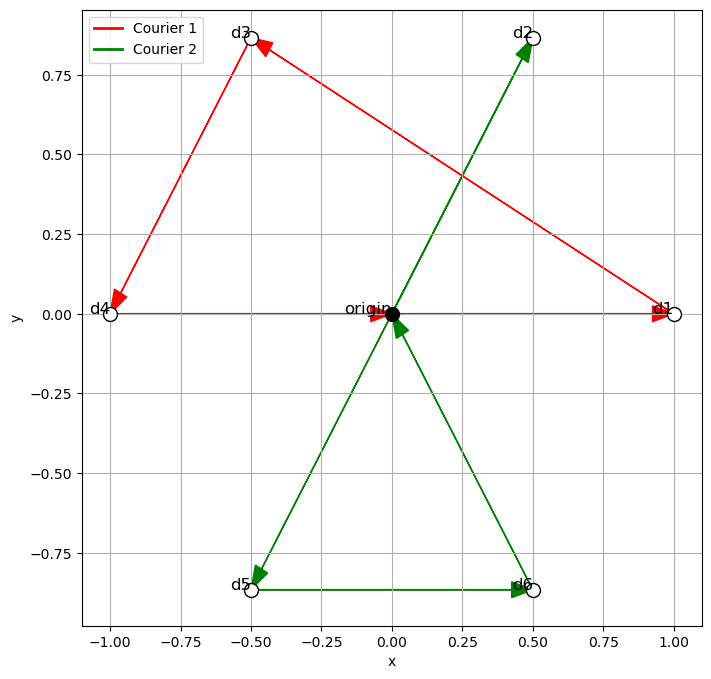

Instance: inst02.dat
Max Distance: 226
Courier 1: Items [1, 4]
Courier 1 Route: [9, 3, 0, 9]
Courier 2: Items [6]
Courier 2 Route: [9, 5, 9]
Courier 3: Items [2]
Courier 3 Route: [9, 1, 9]
Courier 4: Items [5]
Courier 4 Route: [9, 4, 9]
Courier 5: Items [3, 7]
Courier 5 Route: [9, 2, 6, 9]
Courier 6: Items [8, 9]
Courier 6 Route: [9, 7, 8, 9]


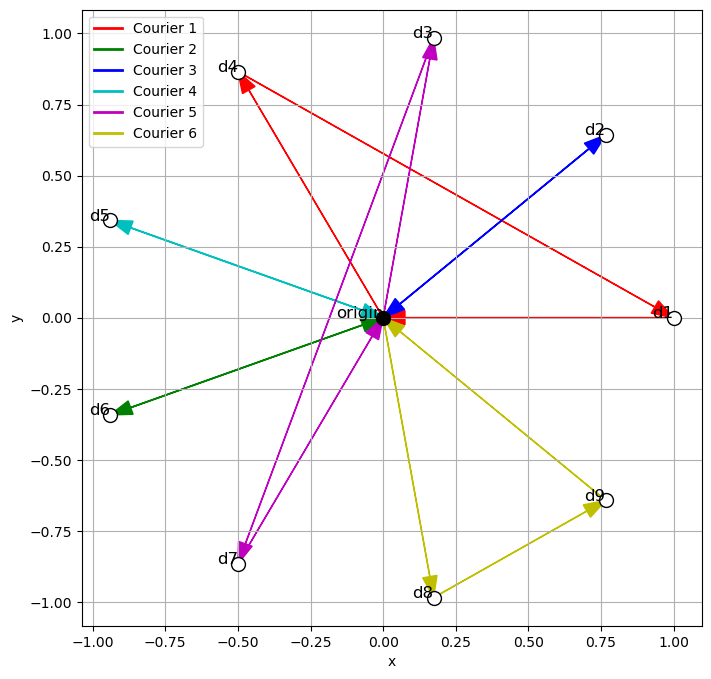

Instance: inst03.dat
Max Distance: 12
Courier 1: Items [2, 4, 5]
Courier 1 Route: [7, 4, 3, 1, 7]
Courier 2: Items [3, 6]
Courier 2 Route: [7, 5, 2, 7]
Courier 3: Items [1, 7]
Courier 3 Route: [7, 6, 0, 7]


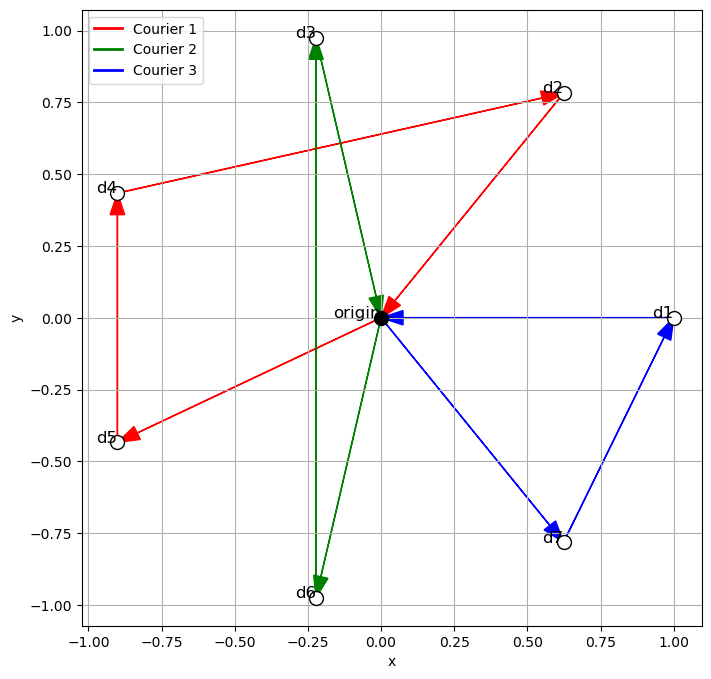

Instance: inst04.dat
Max Distance: 220
Courier 1: Items [2, 4]
Courier 1 Route: [10, 1, 3, 10]
Courier 2: Items [3]
Courier 2 Route: [10, 2, 10]
Courier 3: Items [5]
Courier 3 Route: [10, 4, 10]
Courier 4: Items [9]
Courier 4 Route: [10, 8, 10]
Courier 5: Items [1]
Courier 5 Route: [10, 0, 10]
Courier 6: Items [8]
Courier 6 Route: [10, 7, 10]
Courier 7: Items [7]
Courier 7 Route: [10, 6, 10]
Courier 8: Items [6, 10]
Courier 8 Route: [10, 9, 5, 10]


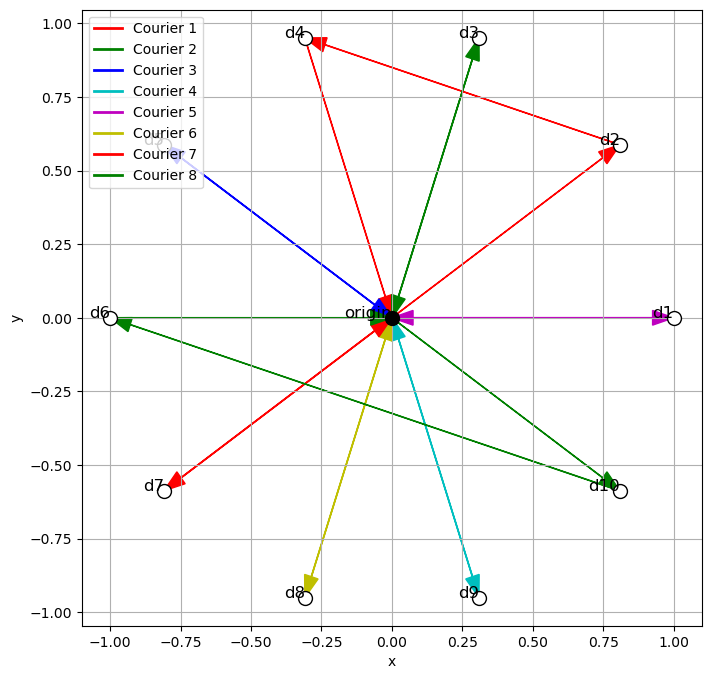

Instance: inst05.dat
Max Distance: 206
Courier 1: Items [2]
Courier 1 Route: [3, 1, 3]
Courier 2: Items [1, 3]
Courier 2 Route: [3, 0, 2, 3]


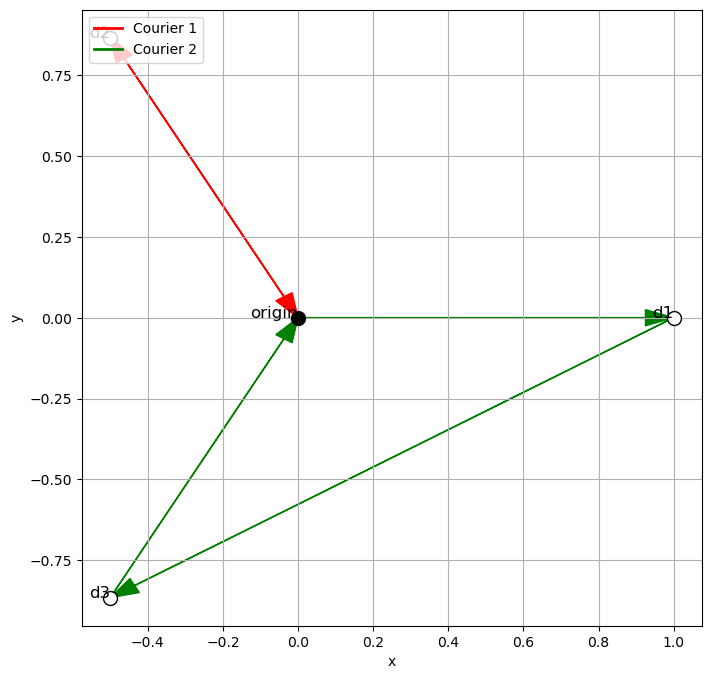

Instance: inst06.dat
Max Distance: 322
Courier 1: Items [5]
Courier 1 Route: [8, 4, 8]
Courier 2: Items [8]
Courier 2 Route: [8, 7, 8]
Courier 3: Items [1]
Courier 3 Route: [8, 0, 8]
Courier 4: Items [4]
Courier 4 Route: [8, 3, 8]
Courier 5: Items [2, 6, 7]
Courier 5 Route: [8, 5, 6, 1, 8]
Courier 6: Items [3]
Courier 6 Route: [8, 2, 8]


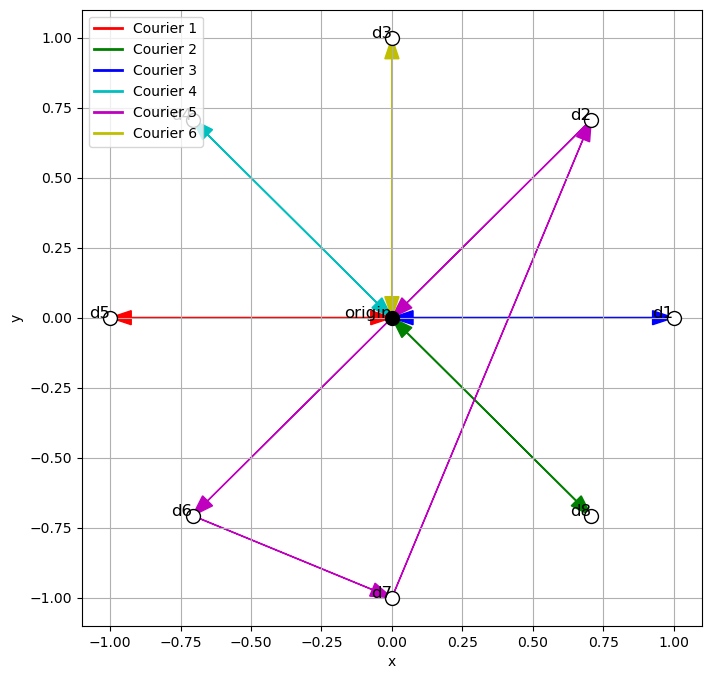

In [ ]:
for instance_name, instance in instances.items():
    m = instance['m']
    n = instance['n']
    l_values = instance['l_values']
    s_values = instance['s_values']
    D = instance['distance_matrix']
    LB, UB = computeBounds(D, m, n)
    solution = solve_mcp(m, n, l_values, s_values, D, LB, UB, time_limit=300)
    print_solution(instance_name, solution, instance)